In [1]:
# Imports
!pip install openpyxl 
import os
import numpy as np
import pandas as pd
import librosa as lb
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Download data and extract features
The following files contain data about the gunshot audio files recorded by our device and were manually labelled by the team to improve the accuracy. "gunshot_data_csv" was the original file with different label categories, we then pre-processed and converted them to one-shot encoding in "one_hot_encoded_cic" file.

In [2]:
raw_gunshot = pd.read_csv('gunshot_data_csv.csv')
raw_gunshot.head()

,Date,Time (GMT),Unnamed: 2,File name,File URL,Unnamed: 5,Owner,Gun Shot (Y/N),"Type of Sound (Gunshot, Unclear, etc.)"
0,6/29/2022,0:59:58,88244,Sample-1 (Tue Jun 28 17:59:55 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,Nilo,Y,Gunshot
1,6/29/2022,15:30:09,88244,Sample-1 (Wed Jun 29 08:30:07 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Rain
2,6/29/2022,15:34:39,88244,Sample-2 (Wed Jun 29 08:34:37 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Muffled sound
3,6/29/2022,15:50:33,88244,Sample-3 (Wed Jun 29 08:50:31 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Muffled sound
4,6/29/2022,17:03:12,88244,Sample-3 (Wed Jun 29 10:03:10 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,Static/none


In [3]:
one_hot = pd.read_excel('one_hot_encoded_cic.xlsx')
one_hot.head()

,Unnamed: 0,Date,Time (GMT),Unnamed: 2,File name,File URL,Unnamed: 5,Owner,Gun Shot (Y/N),Class_Gunshot,Class_Not Gunshot
0,0,2022-06-29,00:59:58,88244,Sample-1 (Tue Jun 28 17:59:55 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,Nilo,Y,1,0
1,1,2022-06-29,15:30:09,88244,Sample-1 (Wed Jun 29 08:30:07 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
2,2,2022-06-29,15:34:39,88244,Sample-2 (Wed Jun 29 08:34:37 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
3,3,2022-06-29,15:50:33,88244,Sample-3 (Wed Jun 29 08:50:31 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1
4,4,2022-06-29,17:03:12,88244,Sample-3 (Wed Jun 29 10:03:10 2022).wav,https://phoenix-pd-gunshot-wav-files.s3.us-wes...,NaN,Nilo,N,0,1


In [ ]:
# download audio files from above csv and keep them in two separate folders
!pip install wget
import wget
import os
import random

if not os.path.exists('./gunshots'):
    os.mkdir('./gunshots/')

if not os.path.exists('./non-gunshots'):
    os.mkdir('./non-gunshots/')

# for index, row in one_hot.iterrows():
#     URL = row['File URL']
#     prefix = './gunshots/' if row['Gun Shot (Y/N)'] == 'Y' else './non-gunshots/'
#     fileName = prefix + str(index) + '.wav'
#     if os.path.exists(fileName):
#         continue
#     response = wget.download(URL, fileName)

In [5]:
# Simple feature extractor that uses Mel transformation 
# to extract mel frequency cepstral coefficients from the audio files
def feature_extractor(path):
    data, simple_rate = lb.load(path)
    data = lb.feature.mfcc(y=data, n_mfcc=128)
    data = np.mean(data,axis=1)
    return data

In [6]:
# Create feature set X for model training
import random
filepaths = []
num_gunshots = len(os.listdir('./gunshots/'))
non_gunshots = [{'isGunshot': False, 'file':x} for x in os.listdir('./non-gunshots/')]

# equal number of gunshots and non gunshots
filepaths.extend([{'isGunshot': True, 'file':x} for x in os.listdir('./gunshots/')])
filepaths.extend(random.sample(non_gunshots, num_gunshots))

In [7]:
# Experiment with other feature types such as 
# spectogram info in decibels, 
# zero crossing of the audio wave, 
# spectral centroid movement and spectral roll off
import sklearn
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# gather spectogram
for _ in range(3):
    rows = random.choice(filepaths)
    directory = './gunshots/' if rows['isGunshot'] else './non-gunshots'
    path = directory + '/' + str(rows['file'])
    x , sr = lb.load(path)
    print(f'this example is a gunshot? -> {rows["isGunshot"]}')    

    spectogram = lb.stft(x)
    spectogram_db = lb.amplitude_to_db(abs(spectogram))
    print(f'spectogram count = {len(spectogram_db)}')
    
    zero_crossings = lb.zero_crossings(x, pad=False)
    print(f'total zero crossings = {sum(zero_crossings)}')
    
    #spectral centroid -- centre of mass -- weighted mean of the frequencies present in the sound
    spectral_centroids = lb.feature.spectral_centroid(x, sr=sr)[0]
    # Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    t = lb.frames_to_time(frames)
    # Normalising the spectral centroid 
    normlaized_spectral_centroid = normalize(spectral_centroids)
    print(f'Normalized Spectral centroid shape -> {normlaized_spectral_centroid.shape}')
    
    spectral_rolloff = lb.feature.spectral_rolloff(x, sr=sr)[0]
    normalized_spectral_rolloff = normalize(spectral_rolloff)
    print(f'Normalized Spectral Rolloff shape -> {normalized_spectral_rolloff.shape}')
    print('-------------------------------------')

this example is a gunshot? -> True
spectogram count = 1025
total zero crossings = 1234
Normalized Spectral centroid shape -> (87,)
Normalized Spectral Rolloff shape -> (87,)
-------------------------------------
this example is a gunshot? -> False
spectogram count = 1025
total zero crossings = 1381
Normalized Spectral centroid shape -> (87,)
Normalized Spectral Rolloff shape -> (87,)
-------------------------------------
this example is a gunshot? -> True
spectogram count = 1025
total zero crossings = 1744
Normalized Spectral centroid shape -> (87,)
Normalized Spectral Rolloff shape -> (87,)
-------------------------------------


In [8]:
# Create the X feature set and y Labels
x, y = [], []
for rows in tqdm(filepaths):
    try:
        directory = './gunshots/' if rows['isGunshot'] else './non-gunshots'
        path = directory + '/' + str(rows['file'])
        x.append(feature_extractor(path))
        y.append(1 if rows['isGunshot'] else 0)
    except Exception as e:
        print(e)
x = np.array(x)
y = np.array(y)
x.shape, y.shape

100%|██████████| 290/290 [00:03<00:00, 86.93it/s] 


((290, 128), (290,))

In [9]:
y = to_categorical(y)
y.shape

(290, 2)

In [10]:
xtrainval, xtest, ytrainval, ytest = train_test_split(
    x, y, test_size=0.1, stratify=y, random_state=42)
xtrain, xvalid, ytrain, yvalid = train_test_split(
    xtrainval, ytrainval, test_size=0.2, stratify=ytrainval, random_state=42)
print('\nNumber of samples for Train set :', xtrain.shape[0])
print('Number of samples for Validation set :', xvalid.shape[0])
print('Number of samples for Test set :', xtest.shape[0])



Number of samples for Train set : 208
Number of samples for Validation set : 53
Number of samples for Test set : 29


In [11]:
# Create a simple FCNN
model = Sequential(
                        [
                            layers.Dense(1000,activation='relu',input_shape=(128,)),
                            layers.Dense(750,activation='relu'),
                            layers.Dense(500,activation='relu'),
                            layers.Dense(250,activation='relu'),
                            layers.Dense(100,activation='relu'),
                            layers.Dense(50,activation='relu'),
                            layers.Dense(10,activation='relu'),
                            layers.Dense(2,activation='softmax')
                        ]
                   )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              129000    
                                                                 
 dense_1 (Dense)             (None, 750)               750750    
                                                                 
 dense_2 (Dense)             (None, 500)               375500    
                                                                 
 dense_3 (Dense)             (None, 250)               125250    
                                                                 
 dense_4 (Dense)             (None, 100)               25100     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 10)                5

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
training = model.fit(xtrain,ytrain,validation_data=(xvalid,yvalid),epochs=100)

Epoch 1/100
7/7 [==============================] - 5s 179ms/step - loss: 4.4617 - accuracy: 0.4183 - val_loss: 0.7090 - val_accuracy: 0.5094
Epoch 2/100
7/7 [==============================] - 0s 35ms/step - loss: 0.6771 - accuracy: 0.5433 - val_loss: 1.0608 - val_accuracy: 0.4906
Epoch 3/100
7/7 [==============================] - 0s 32ms/step - loss: 0.9244 - accuracy: 0.5433 - val_loss: 1.6221 - val_accuracy: 0.5094
Epoch 4/100
7/7 [==============================] - 0s 34ms/step - loss: 1.0841 - accuracy: 0.5000 - val_loss: 0.8300 - val_accuracy: 0.5094
Epoch 5/100
7/7 [==============================] - 0s 39ms/step - loss: 0.7576 - accuracy: 0.5240 - val_loss: 0.7857 - val_accuracy: 0.4906
Epoch 6/100
7/7 [==============================] - 0s 29ms/step - loss: 0.6601 - accuracy: 0.6010 - val_loss: 0.8819 - val_accuracy: 0.4906
Epoch 7/100
7/7 [==============================] - 0s 27ms/step - loss: 0.7861 - accuracy: 0.5529 - val_loss: 0.8171 - val_accuracy: 0.4906
Epoch 8/100
7/7 [==

In [13]:
train_hist = pd.DataFrame(training.history)
train_hist

,loss,accuracy,val_loss,val_accuracy
0,4.461736,0.418269,0.709026,0.509434
1,0.677050,0.543269,1.060810,0.490566
2,0.924394,0.543269,1.622121,0.509434
3,1.084130,0.500000,0.829959,0.509434
4,0.757560,0.524038,0.785687,0.490566
...,...,...,...,...
95,0.027404,0.995192,1.505706,0.811321
96,0.015637,0.990385,0.995116,0.792453
97,0.003361,1.000000,1.079018,0.811321
98,0.003517,1.000000,1.132470,0.811321


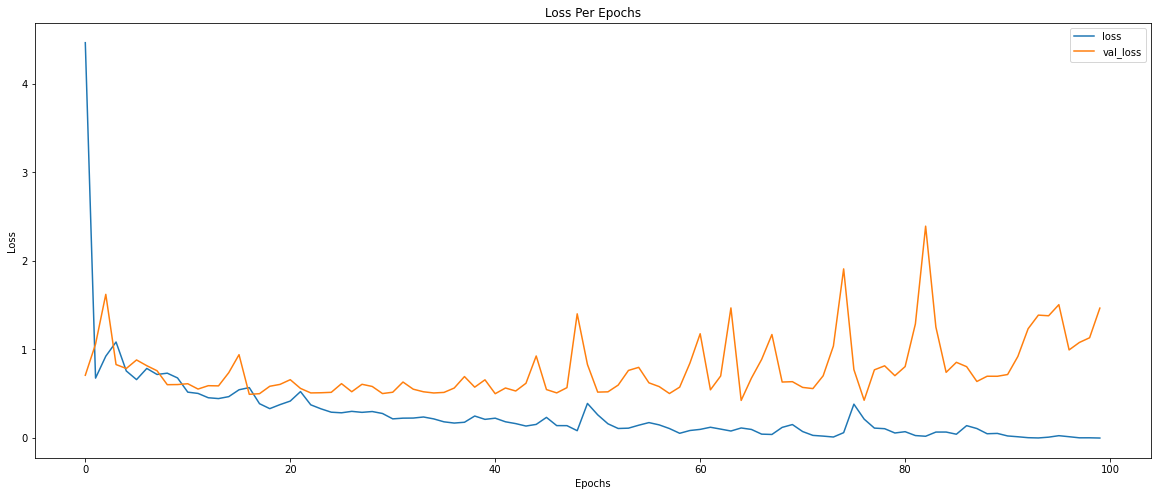

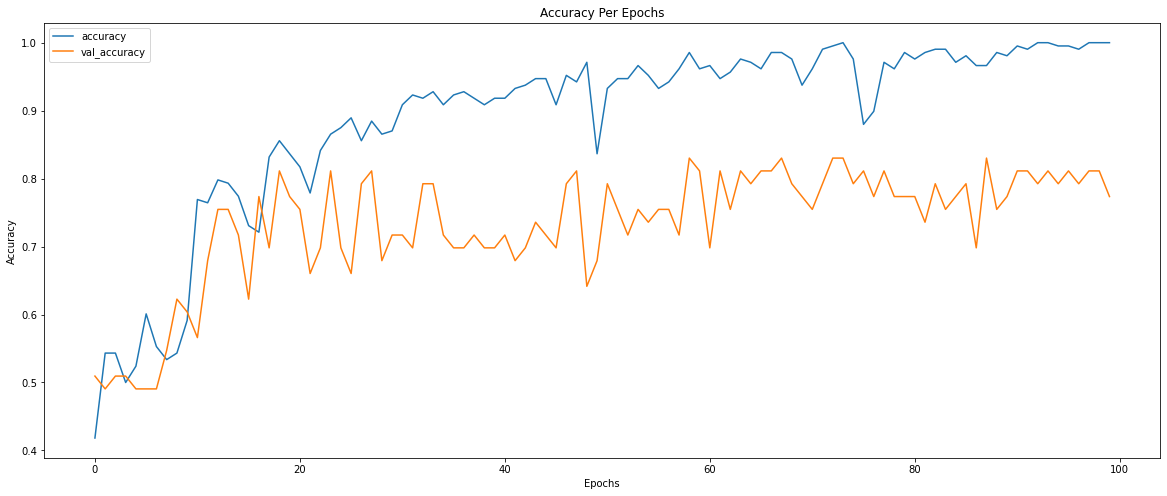

In [14]:
plt.figure(figsize=(20,8))
plt.plot(train_hist[['loss','val_loss']])
plt.legend(['loss','val_loss'])
plt.title('Loss Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_hist[['accuracy','val_accuracy']])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy Per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [15]:
ytrue = np.argmax(ytest,axis=1)
ypred = np.argmax(model.predict(xtest),axis=1)
print('\nConfusion Matrix :\n\n')
print(confusion_matrix(ytrue,ypred))
print('\n\nClassification Report : \n\n',classification_report(ytrue,ypred))

1/1 [==============================] - 0s 271ms/step

Confusion Matrix :


[[12  2]
 [ 3 12]]


Classification Report : 

               precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.86      0.80      0.83        15

    accuracy                           0.83        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.83      0.83      0.83        29



In [16]:
import pickle
pickle.dump(model, open('filter.h5','wb'))
model.save('./keras_filter.h5')

INFO:tensorflow:Assets written to: ram://4916c495-5d93-4a78-9d71-e32e9802a296/assets


In [17]:
def predict(path, actual):
    audio = np.array([feature_extractor(path)])
    classid = np.argmax(model.predict(audio)[0])
    # print('Class predicted :','gunshot' if classid else 'not a gunshot', 'and was', 'gunshot' if actual else 'not a gunshot','\n\n')
    print(f"For file at {path}, \nclass predicted : {'gunshot' if classid else 'not a gunshot'} -> { 'gunshot' if actual else 'not a gunshot'}")
    return ipd.Audio(path)


In [18]:
import random
samples = 20
for _ in range(samples):
    choice = random.choice(filepaths)
    directory = './gunshots/' if choice['isGunshot'] else './non-gunshots'
    path = directory + '/' + str(choice['file'])
    predict(path, choice['isGunshot'])

1/1 [==============================] - 0s 40ms/step
For file at ./gunshots//1002.wav, 
class predicted : gunshot -> gunshot
1/1 [==============================] - 0s 49ms/step
For file at ./gunshots//1164.wav, 
class predicted : gunshot -> gunshot
1/1 [==============================] - 0s 36ms/step
For file at ./non-gunshots/1429.wav, 
class predicted : gunshot -> not a gunshot
1/1 [==============================] - 0s 39ms/step
For file at ./gunshots//3806.wav, 
class predicted : gunshot -> gunshot
1/1 [==============================] - 0s 48ms/step
For file at ./non-gunshots/288.wav, 
class predicted : not a gunshot -> not a gunshot
1/1 [==============================] - 0s 29ms/step
For file at ./non-gunshots/54.wav, 
class predicted : not a gunshot -> not a gunshot
1/1 [==============================] - 0s 30ms/step
For file at ./non-gunshots/386.wav, 
class predicted : not a gunshot -> not a gunshot
1/1 [==============================] - 0s 31ms/step
For file at ./gunshots//2305.w